[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things:

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
# Set up Langsmith Tracing
import getpass
import os

# Get keys from "https://smith.langchain.com/" >> "Tracing Projects" >> "LangGraph-Course"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LANGCHAIN_API_KEY: ")
os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LANGSMITH_API_KEY: ") # Add same
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph-Course"

Enter your LANGCHAIN_API_KEY: ··········
Enter your LANGSMITH_API_KEY: ··········


In [4]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")
os.environ["AZURE_OPENAI_API_KEY"] = getpass.getpass("Enter your AZURE_OPENAI_API_KEY: ")
os.environ["AZURE_OPENAI_ENDPOINT"] = getpass.getpass("Enter your AZURE_OPENAI_ENDPOINT: ")

Enter your AZURE_OPENAI_API_KEY: ··········
Enter your AZURE_OPENAI_ENDPOINT: ··········


We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

In [5]:
# _set_env("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [8]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [9]:
# from langchain_openai import ChatOpenAI
from langchain_openai import AzureChatOpenAI

# llm = ChatOpenAI(model="gpt-4o")

llm = AzureChatOpenAI(
    azure_deployment="gpt4-model",  # or your deployment
    api_version="2023-05-15",  # or your api version
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

llm.invoke(messages)

AIMessage(content='In addition to whales, there are several other ocean mammals you can learn about. Some of them include:\n\n1. Dolphins: Highly intelligent and social marine mammals, known for their playful behavior and acrobatic displays. There are over 40 species of dolphins, including the well-known bottlenose dolphin.\n\n2. Porpoises: Similar to dolphins but with a more rounded body shape and a shorter snout. There are seven species of porpoises, including the harbor porpoise and the vaquita.\n\n3. Manatees: Also known as sea cows, these gentle herbivores are found in warm coastal waters and rivers. There are three species of manatees: the West Indian manatee, the Amazonian manatee, and the African manatee.\n\n4. Dugongs: Closely related to manatees, dugongs are found in the warm coastal waters of the Indian and Pacific Oceans. They are the only strictly marine herbivorous mammal, feeding mainly on seagrass.\n\n5. Sea otters: These small marine mammals are found in the coastal wa

We can run our chat model in a simple graph with `MessagesState`.

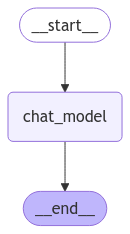

In [11]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other ocean mammals you can learn about. Some of them include:

1. Dolphins: Highly intelligent and social marine mammals, known for their playful behavior and acrobatic displays. There are over 40 species of dolphins, including the well-known bottlenose dolphin.

2. Porpoises: Similar to dolphins but with a more rounded body shape and a shorter snout. There are seven species of porpoises, including the harbor porpoise and the vaquita.

3. Manatees: Also known as sea cows, these gentle herbivores are found in warm coastal waters and rivers. There are three species of manat

## Reducer

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

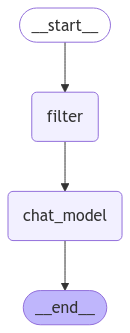

In [13]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

AttributeError: 'list' object has no attribute 'split'

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

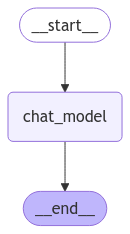

In [31]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [32]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [33]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Narwhals, also known as Monodon monoceros, are medium-sized toothed whales that belong to the Monodontidae family. They are found primarily in the Arctic waters around Greenland, Canada, and Russia. Narwhals are known for their distinct long, spiral tusks, which are actually elongated canine teeth that can grow up to 10 feet (3 meters) in length. These tusks are more commonly found in males, while only about 15% of females

In [34]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Narwhals, also known as Monodon monoceros, are medium-sized toothed whales that belong to the Monodontidae family. They are found primarily in the Arctic waters around Greenland, Canada, and Russia. Narwhals are known for their distinct long, spiral tusks, which are actually elongated canine teeth that can grow up to 10 feet (3 meters) in length. These tusks are more commonly found in males, while only about 15% of females

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

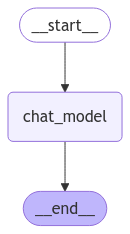

In [39]:
from langchain_core.messages import trim_messages

def get_token_len(messages):
    """Dummy token counter function"""
    token_count = 0
    for messages in messages:
        token_count += len(messages.content.split())
    return token_count


# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            # token_counter=ChatOpenAI(model="gpt-4o"),
            token_counter=get_token_len,
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [41]:
# Example of trimming messages

trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            # token_counter=ChatOpenAI(model="gpt-4o"),
            token_counter=get_token_len,
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [43]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})
messages_out_trim

{'messages': [AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
  HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
  AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
  AIMessage(content='Narwhals, also known as Monodon monoceros, are medium-sized toothed whales that belong to the Monodontidae family. They are found primarily in the Arctic waters around Greenland, Canada, and Russia. Narwhals are known for their distinct long, spiral tusks, which are actually elongated canine teeth that can grow up to 10 feet (3 meters) in length. These tusks are more commonly found in males, while only about 15% of females have them.\n\nNarwhals are medium-sized whales, measuring 

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r